In [1]:
import os

import mysql.connector
import pandas as pd

from datetime import datetime

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [2]:
start = datetime.now()
print("start = ", start)
try:
    
    mydb = mysql.connector.connect(
        host=os.environ['MYSQL_SPOTIFY_HOST'],
        user=os.environ['MYSQL_SPOTIFY_USER'],
        password=os.environ['MYSQL_SPOTIFY_PW'],
        database="wilts_songs"
    )

    mycursor = mydb.cursor()
    mycursor.execute("""SELECT * FROM songs_full;""")

    data = mycursor.fetchall()
except mysql.connector.Error as error:
    print("Failed to insert into MySQL table {}".format(error))

finally:
    if mydb.is_connected():
        mycursor.close()
        mydb.close()
        print("MySQL connection is closed")
    end = datetime.now()
    print("finish = ", end)
    print("duration = ", (end-start).total_seconds())

start =  2022-08-26 23:55:29.844136
MySQL connection is closed
finish =  2022-08-26 23:55:30.186107
duration =  0.341971


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
columns = ['id', 'track_name', 'artist_name', 'popularity', 'duration_ms',
        'danceability', 'time_signature', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
        'instrumentalness', 'liveness', 'valence', 'tempo']

nominal_cols = ['id', 'track_name', 'artist_name']
discret_cols = ['key', 'mode']
continuous_cols = ['popularity', 'duration_ms', 'danceability', 'time_signature', 'loudness', 'speechiness',
        'instrumentalness', 'liveness', 'valence', 'tempo', 'acousticness*energy'] 
useful_cols = discret_cols + continuous_cols

In [5]:
df = pd.DataFrame(data, columns=columns)

In [6]:
df['acousticness*energy']=df['acousticness']*df['energy']

On retire les colonnes energy et acousticness des colonnes utilisées pour le modèle et on ajoute acousticness*energy vu les conclusions de l'analyse de la donnée.

In [7]:
df=df[useful_cols]

In [8]:
df.describe()

,key,mode,popularity,duration_ms,danceability,time_signature,loudness,speechiness,instrumentalness,liveness,valence,tempo,acousticness*energy
count,61116.000000,61116.000000,61116.000000,6.111600e+04,61116.000000,61116.000000,61116.000000,61116.000000,61116.000000,61116.000000,61116.000000,61116.00000,61116.000000
mean,5.241361,0.700373,42.683536,2.362429e+05,0.562745,3.905622,-9.759729,0.072762,0.127186,0.202740,0.556389,120.58324,0.139394
std,3.531235,0.458098,20.443069,1.395302e+05,0.168019,0.385231,4.644889,0.084394,0.276436,0.177193,0.257077,29.00575,0.135810
min,0.000000,0.000000,0.000000,1.200000e+04,0.000000,0.000000,-47.070000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,2.000000,0.000000,33.000000,1.762270e+05,0.449000,4.000000,-12.224000,0.033300,0.000000,0.093100,0.351000,98.03300,0.019800
50%,5.000000,1.000000,44.000000,2.197070e+05,0.570000,4.000000,-8.968000,0.043000,0.000106,0.130000,0.569000,119.86500,0.104606
75%,8.000000,1.000000,57.000000,2.708670e+05,0.684000,4.000000,-6.430000,0.068200,0.027025,0.261000,0.773000,137.81125,0.223585
max,11.000000,1.000000,100.000000,4.800118e+06,0.988000,5.000000,3.744000,0.961000,1.000000,0.997000,0.994000,243.37200,0.968252


In [9]:
numeric_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])

In [10]:
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, useful_cols),
])



In [11]:
from sklearn.cluster import KMeans, Birch

Choix modèle: https://scikit-learn.org/stable/modules/clustering.html  
Gridsearch avec unsupervised: https://stackoverflow.com/questions/44636370/scikit-learn-gridsearchcv-without-cross-validation-unsupervised-learning

In [12]:
from sklearn import metrics
def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator['model'].labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
#     if num_labels == 1 or num_labels == num_samples:
#         return -1
#     else:
#         return metrics.silhouette_score(X, cluster_labels)
    return metrics.silhouette_score(X, cluster_labels)

# cv = [(slice(None), slice(None))]
# gs = GridSearchCV(estimator=sklearn.cluster.MeanShift(), param_grid=param_dict, 
#                   scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)
# gs.fit(df[cols_of_interest])

In [13]:
from sklearn.model_selection import GridSearchCV


On ne teste plus avec AffinityPropagation car les résultats avec les 18.000 valeurs étaient médiocres et la mémoire utilisée est trop élevée avec 60.000 valeurs (30 Go)

In [15]:
param_dict_kmeans = {'model__n_clusters': [75, 50, 25, 40, 60, 15, 20, 1], 'model__max_iter': [300], 'model__n_init':[5,10,20]}

km = KMeans()

km_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', km)
])

search = GridSearchCV(km_pipeline, param_dict_kmeans,  
                      scoring=cv_silhouette_scorer)

_ = search.fit(df)

print('Best score:', abs(search.best_score_))

print('Best params:', search.best_params_)


Best score: 0.15903263095403924
Best params: {'model__max_iter': 300, 'model__n_clusters': 15, 'model__n_init': 5}


In [ ]:
# param_dict_birch = {'model__n_clusters': [5,7,9,11,13,15,17,19,21, None], 'model__branching_factor': [10, 25, 50]}

# birch = Birch()

# birch_pipeline = Pipeline(steps=[
#     ('preprocess', full_processor),
#     ('model', birch)
# ])

# search = GridSearchCV(birch_pipeline, param_dict_birch, 
#                       cv=cv, 
#                       scoring=cv_silhouette_scorer)

# _ = search.fit(df)

# print('Best score:', abs(search.best_score_))

# print('Best params:', search.best_params_)



In [16]:
search.__dict__

{'scoring': <function __main__.cv_silhouette_scorer(estimator, X)>,
 'estimator': Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('number',
                                                   Pipeline(steps=[('scale',
                                                                    MinMaxScaler())]),
                                                   ['key', 'mode', 'popularity',
                                                    'duration_ms',
                                                    'danceability',
                                                    'time_signature', 'loudness',
                                                    'speechiness',
                                                    'instrumentalness',
                                                    'liveness', 'valence',
                                                    'tempo',
                                                    'acousticness*energy'])])),
         

In [17]:
import numpy as np

Nombre de clusters : 

In [18]:
nr_cluster = len(np.unique(search.predict(df)))

Enregistrer les résultats du modele sur mysql pour faire des suggestion à l'utilisateur ensuite ?   
Lire l'extrait sur l'app de la chanson comparée, et éventuellement des suggestions  
Collecter info sur app : satisfait ou non de la conclusion du bot pour éventuellement faire du ml pour la partie 2 plutôt que des stats 

In [19]:
model=search.best_estimator_

For n_clusters = 15 The average silhouette_score is : 0.1474754260433845


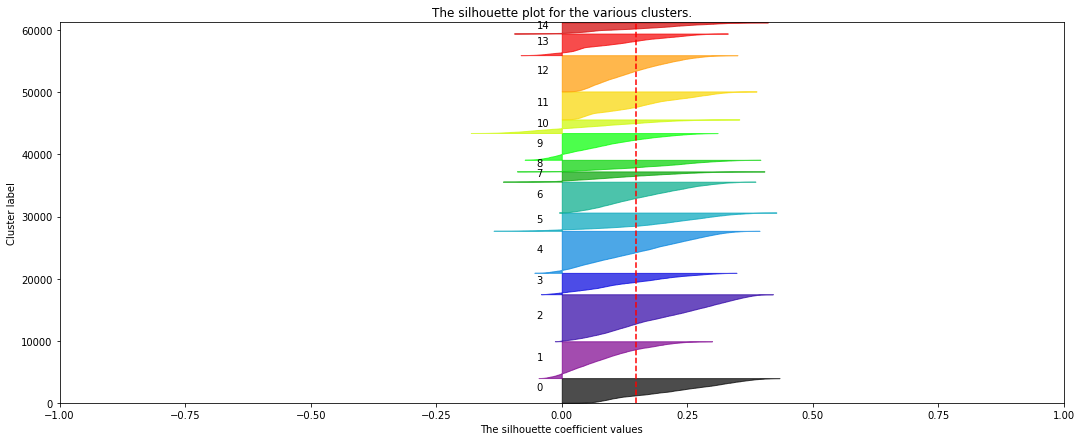

In [20]:
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X, y = make_blobs(
#     n_samples=500,
#     n_features=2,
#     centers=4,
#     cluster_std=1,
#     center_box=(-10.0, 10.0),
#     shuffle=True,
#     random_state=1,
# )  # For reproducibility

X=df


range_n_clusters = [nr_cluster]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
#     fig, (ax1, ax2) = plt.subplots(1, 2)
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = model.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(model.named_steps.preprocess.transform(X), cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(model.named_steps.preprocess.transform(X), cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


plt.show()

Save the model with pickle

In [21]:

import pickle
filename = 'fullkmeans1474+15.sav'
pickle.dump(search.best_estimator_, open(filename, 'wb'))

